In [56]:
import os
env_vars = !cat /home/jahanpd/.keys
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

import pickle
import numpy as np
import random 

random.seed(42)
# get question to experiment with
generations = pickle.load(open('./data/openai_temp=1.0_reasoning=False_generations.pkl', 'rb'))
semsim = pickle.load(open('./data/openai_gpt_oneshot=True_reas=False_temp=1.0_semantic_similarity.pkl', 'rb'))
semsimOG = pickle.load(open('./data/openai_gpt_oneshot=False_reas=False_temp=1.0_semantic_similarity.pkl', 'rb'))
confidence = pickle.load(open("./data/openai_gpt_oneshot=False_temp=0.2_reas=False_agg=original_confidence.pkl", 'rb'))


def count_clusters(d):
    return len(np.unique(list(d.values())))

def is_n_clusters(d, n=4):
    return count_clusters(d) == n

subset = [key for key, value in semsimOG.items() if is_n_clusters(value)]
questions = [qn for qn in generations if qn["id"] in subset]
sample = random.sample(questions, 20)

2.7377245508982035 2.0
2.1808383233532935 2.0


(array([736.,   0., 424.,   0.,   0., 239.,   0.,   0., 122.,   0.,   0.,
         79.,   0.,  48.,   0.,   0.,  10.,   0.,   0.,   9.,   0.,   0.,
          2.,   0.,   1.]),
 array([ 1.  ,  1.36,  1.72,  2.08,  2.44,  2.8 ,  3.16,  3.52,  3.88,
         4.24,  4.6 ,  4.96,  5.32,  5.68,  6.04,  6.4 ,  6.76,  7.12,
         7.48,  7.84,  8.2 ,  8.56,  8.92,  9.28,  9.64, 10.  ]),
 <BarContainer object of 25 artists>)

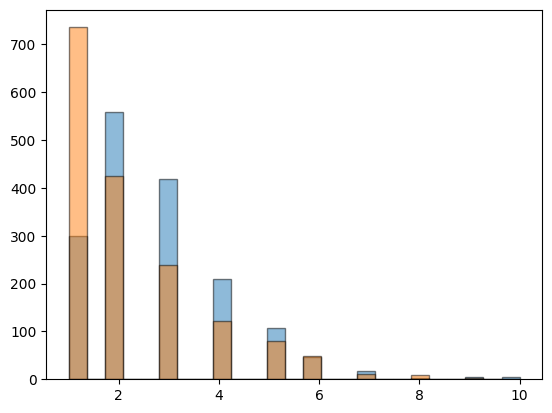

In [58]:
import matplotlib.pyplot as plt
oneshot = [len(np.unique(list(d.values()))) for d in semsim.values()]
og = [len(np.unique(list(d.values()))) for d in semsimOG.values()]
print(np.mean(oneshot), np.median(oneshot))
print(np.mean(og), np.median(og))
plt.hist(oneshot, bins=25, edgecolor='black', alpha=0.5)
plt.hist(og, bins=25, edgecolor='black', alpha=0.5)

In [61]:
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, HTML

def display_answers(index):
    group_colours = {
        'group1': '#e6194B',  # Red
        'group2': '#3cb44b',  # Green
        'group3': '#ffe119',  # Yellow
        'group4': '#4363d8',  # Blue
        'group5': '#f58231',  # Orange
        'group6': '#911eb4',  # Purple
        'group7': '#46f0f0',  # Cyan
        'group8': '#f032e6',  # Magenta
        'group9': '#bcf60c',  # Lime
        'group10': '#fabebe',  # Pink
    }

    def create_list_html(items, groups, sort=False):
        ans_group = list(zip(items, groups))
        if sort:
            ans_group.sort(key=lambda x: x[1])
        html = '<ul>'
        for idx, (text, group) in enumerate(ans_group):
            colour = group_colours.get(f"group{group}", '#000000')
            html += f'<li style="color:{colour}">{idx}. {text}</li>'
        html += '</ul>'
        return html

    list_one = create_list_html(sample[index]["generated_answers"], semsim[sample[index]["id"]].values())
    list_two = create_list_html(sample[index]["generated_answers"], semsimOG[sample[index]["id"]].values())

    output = widgets.Output()
    button = widgets.Button(description='Toggle Sort')

    state = {"sort": False}
    # Define the toggle function
    def toggle_sort(b):
        state["sort"] = not state["sort"]
        output.clear_output()
        with output:
            list_one = create_list_html(sample[index]["generated_answers"], semsim[sample[index]["id"]].values(), state["sort"])
            list_two = create_list_html(sample[index]["generated_answers"], semsimOG[sample[index]["id"]].values(), state["sort"])
            display(button)
            print("Oneshot")
            display(HTML(list_one))
            print("Original")
            display(HTML(list_two))

    button.on_click(toggle_sort)

    with output:
        list_one = create_list_html(sample[index]["generated_answers"], semsim[sample[index]["id"]].values(), state["sort"])
        list_two = create_list_html(sample[index]["generated_answers"], semsimOG[sample[index]["id"]].values(), state["sort"])
        display(button)
        print("Oneshot")
        display(HTML(list_one))
        print("Original")
        display(HTML(list_two))

    display(output)

In [5]:
display_answers(0)

Output()

In [12]:
display_answers(2)

Output()

In [7]:
display_answers(2)

Output()

In [8]:
display_answers(3)



Output()

In [59]:
display_answers(4)

Output()

In [10]:
display_answers(5)

Output()

In [11]:
display_answers(6)

Output()

In [24]:
import networkx as nx
from entailment import get_oneshot_gpt_entailment
from entailment import get_gpt_entailment

def process_sequence(s):
        print("id ", s['id'], "gpt")
        question = s["question"]
        answers = s["generated_answers"]
        answers_idx = list(range(len(answers)))
        random.shuffle(answers_idx)
        print(answers_idx)
        # base semantic set 
        semantic_set_ids = {}
        for idx, answer in enumerate(answers):
            # initialize with a bad answer
            semantic_set_ids[idx] = -1

        # Keep track of current id.
        next_id = 0
        for i, idx in enumerate(answers_idx):
            # this inner loop compared each gen ans with other answers

            # Check if string1 already has an id assigned.
            if semantic_set_ids[i] == -1:
                semantic_set_ids[i] = next_id
                # If string1 has not been assigned an id, assign it next_id.
                for j in range(i + 1, len(answers)):
                    entailed = get_gpt_entailment(
                            question,
                            answers[idx],
                            answers[answers_idx[j]],
                            strict=True
                            )
                    if entailed:
                        semantic_set_ids[j] = semantic_set_ids[i]
                next_id += 1

        return (s['id'], semantic_set_ids)

In [25]:
sequence1 = process_sequence(sample[-2])
sequence2 = process_sequence(sample[-2])
print(sequence1)
print(sequence2)

id  967 gpt
[5, 7, 4, 9, 8, 2, 6, 3, 0, 1]


id  967 gpt
[0, 3, 9, 6, 8, 2, 1, 5, 7, 4]
(967, {0: 0, 1: 1, 2: 1, 3: 2, 4: 0, 5: 3, 6: 2, 7: 3, 8: 3, 9: 1})
(967, {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 0, 6: 3, 7: 2, 8: 3, 9: 3})


In [26]:
print(sequence1[1].values())
print(sequence2[1].values())

dict_values([0, 1, 1, 2, 0, 3, 2, 3, 3, 1])
dict_values([0, 0, 1, 1, 2, 0, 3, 2, 3, 3])


In [52]:
answers = ["a dog", "a canine", "a cat", "a bird"]
embeddings = [0, -1, 4, 10]

distances = {}
max_distance = 0
for i in range(len(answers)):
    compare = {}
    for j in range(len(answers)):
        if i != j:
            distance = abs(embeddings[i] - embeddings[j])
            compare[j] = distance
            if distance >= max_distance:
                max_distance = distance
    distances[i] = compare

print(distances)
print(max_distance)
print(set(sum([list(d.values()) for d in distances.values()], [])))

# compare the strings furthest from all others in embedding space
order = []
for key, value in distances.items():
    order.append((key, sum(value.values())))

order.sort(key=lambda x: -x[1])
print([x[0] for x in order])

{0: {1: 1, 2: 4, 3: 10}, 1: {0: 1, 2: 5, 3: 11}, 2: {0: 4, 1: 5, 3: 6}, 3: {0: 10, 1: 11, 2: 6}}
11
{1, 4, 5, 6, 10, 11}
[3, 1, 0, 2]


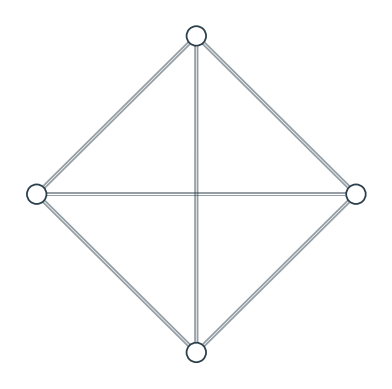

In [39]:
import matplotlib.pyplot as plt
from netgraph import Graph

G = nx.Graph()
G.add_nodes_from([0,1,2,3])
for i in range(4):
    for j in range(4):
        if i != j:
            G.add_edge(i, j, length=distances[i][j])
pos = nx.spring_layout(G, weight='length')
nx.draw(G, pos)
nx.draw_networkx_edge_labels(G, pos)
plt.show()